# <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Предсказание будущих продаж</a>

**Задача:***
``Вам предоставляются ежедневные исторические данные о продажах. Задача состоит в прогнозировании общего количества продуктов, проданных в каждом магазине для тестового набора.``

**Описание файлов**: 

- ``sales_train.csv`` - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года.
- ``test.csv`` -  тестовый набор. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.
- ``sample_submission.csv`` - файл с примерами представления в правильном формате.
- ``items.csv``  - дополнительная информация о товарах / товарах.
- ``item_categories.csv``  - дополнительная информация о категориях товаров.
- ``shops.csv``- дополнительная информация о магазинах.

**Поля данных**: 

- ``ID``- идентификатор, который представляет кортеж (магазин, товар) в тестовом наборе
- ``shop_id`` - уникальный идентификатор магазина
- ``item_id`` - уникальный идентификатор товара
- ``item_category_id``  - уникальный идентификатор категории товара
- ``item_cnt_day`` - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры
- ``item_price``  - текущая цена товара
- ``data`` - дата в формате дд / мм / гггг
- ``date_block_num`` - порядковый номер месяца, используемый для удобства. В январе 2013 года - 0, в феврале 2013 года - 1, ..., в октябре 2015 года - 33
- ``item_name`` - название предмета
- ``shop_name``  - название магазина
- ``item_category_name`` - название категории товара

Подключим все необходимые библиотеки для обработки данных

In [1]:
import gc # сборщик мусора для удаления ненужных данных в оперативной памяти
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Проверка данных

Загружаем наши данные, просмотрим их и проверяем на наличие пустых значений

In [26]:
train = pd.read_csv(r'./datasets/sales_train.csv')
test = pd.read_csv(r'./datasets/test.csv')
sample_sub = pd.read_csv(r'./datasets/sample_submission.csv')
items = pd.read_csv(r'./datasets/items.csv')
items_cat = pd.read_csv(r'./datasets/item_categories.csv')
shops = pd.read_csv(r'./datasets/shops.csv')

In [4]:
items_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
items_cat.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [11]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [11]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [12]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [4]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

# Преобразование данных

Приведем наши данные к необходимому формату, объединим таблицы. Удалим из train выборки то чего нет в test выборке. Добавим новые признаки. Приведем целевую переменную item_cnt_day к формату 0, 20.

In [31]:
test_shops = test.shop_id.unique() # в train выборке у нас есть магазины и товары которых нет в test выборке
train = train[train.shop_id.isin(test_shops)] # поэтому мы их удалим
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [32]:
def split_city(str):
  return str.split(sep=" ", maxsplit=1)[0]

def split_shop(str):
  return str.split(sep=" ", maxsplit=1)[1]

def split_item_cat1(str):
  return str.split(sep="-", maxsplit=1)[0]

def split_item_cat2(str):
  splitted = str.split(sep="-", maxsplit=1)
  if len(splitted) == 1:
    return "No info"
  else:
    return splitted[1]

def prepare_data(data): # функция для объединения таблиц и создания новых признаков из старых
  full_items = items.merge(items_cat, left_on="item_category_id", right_on="item_category_id")
  full_data = data.merge(shops, left_on="shop_id", right_on="shop_id").merge(full_items, left_on="item_id", right_on="item_id")
  del full_items
  full_data['city'] = full_data['shop_name'].apply(split_city)
  full_data['new_shop_name'] = full_data['shop_name'].apply(split_shop)
  full_data['item_cat1'] = full_data['item_category_name'].apply(split_item_cat1)
  full_data['item_cat2'] = full_data['item_category_name'].apply(split_item_cat2)
  full_data.drop(['shop_id', 'item_id', 'shop_name', 'item_name', 'item_category_id', 'item_category_name'], axis=1, inplace=True)
  return full_data

In [33]:
%%time
new_train = prepare_data(train.copy())
new_test = prepare_data(test.copy())

CPU times: user 4.42 s, sys: 732 ms, total: 5.15 s
Wall time: 5.5 s


In [34]:
new_test['date_block_num'] = 34 # добавляем порядковый номер месяца в test
new_test.drop(['ID'], axis=1, inplace=True)
new_train.drop(['date'], axis=1, inplace=True)
new_train['item_cnt_day'] = new_train['item_cnt_day'].clip(0, 20) # преобразуем значения item_cnt_day в необходимый формат > 0
new_train['month'] = new_train['date_block_num'] % 12 # добавляем номер месяца в train
new_test['month'] = new_test['date_block_num'] % 12 # добавляем номер месяца в test
new_train.drop(['item_price'], axis=1, inplace=True)

In [35]:
gc.collect()

177

In [36]:
new_train

,date_block_num,item_cnt_day,city,new_shop_name,item_cat1,item_cat2,month
0,0,1.0,Ярославль,"ТЦ ""Альтаир""",Кино,Blu-Ray,0
1,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
2,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
3,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
4,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
...,...,...,...,...,...,...,...
1224434,33,1.0,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224435,33,1.0,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224436,33,3.0,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9
1224437,33,1.0,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9


In [37]:
new_test

,city,new_shop_name,item_cat1,item_cat2,date_block_num,month
0,Вологда,"ТРЦ ""Мармелад""",Игры,PS3,34,10
1,Волжский,"ТЦ ""Волга Молл""",Игры,PS3,34,10
2,Воронеж,"(Плехановская, 13)",Игры,PS3,34,10
3,Балашиха,"ТРК ""Октябрь-Киномир""",Игры,PS3,34,10
4,Адыгея,"ТЦ ""Мега""",Игры,PS3,34,10
...,...,...,...,...,...,...
214195,Сергиев,"Посад ТЦ ""7Я""",Кино,Blu-Ray,34,10
214196,РостовНаДону,"ТЦ ""Мега""",Кино,Blu-Ray,34,10
214197,Самара,"ТЦ ""Мелодия""",Кино,Blu-Ray,34,10
214198,РостовНаДону,"ТРК ""Мегацентр Горизонт""",Кино,Blu-Ray,34,10


# Получение информации о данных

In [21]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 1224438
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1224439 non-null  int64  
 1   item_cnt_day    1224439 non-null  float64
 2   city            1224439 non-null  object 
 3   new_shop_name   1224439 non-null  object 
 4   item_cat1       1224439 non-null  object 
 5   item_cat2       1224439 non-null  object 
 6   month           1224439 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 74.7+ MB


In [22]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   city            214200 non-null  object
 1   new_shop_name   214200 non-null  object
 2   item_cat1       214200 non-null  object
 3   item_cat2       214200 non-null  object
 4   date_block_num  214200 non-null  int64 
 5   month           214200 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.4+ MB


In [23]:
new_train.describe()

,date_block_num,item_cnt_day,month
count,1.224439e+06,1.224439e+06,1.224439e+06
mean,1.935472e+01,1.287587e+00,5.628645e+00
std,9.110722e+00,1.360836e+00,3.470049e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.200000e+01,1.000000e+00,3.000000e+00
50%,2.100000e+01,1.000000e+00,6.000000e+00
75%,2.700000e+01,1.000000e+00,9.000000e+00
max,3.300000e+01,2.000000e+01,1.100000e+01


# Визуализация

Посмотрим количество заказов по городам.

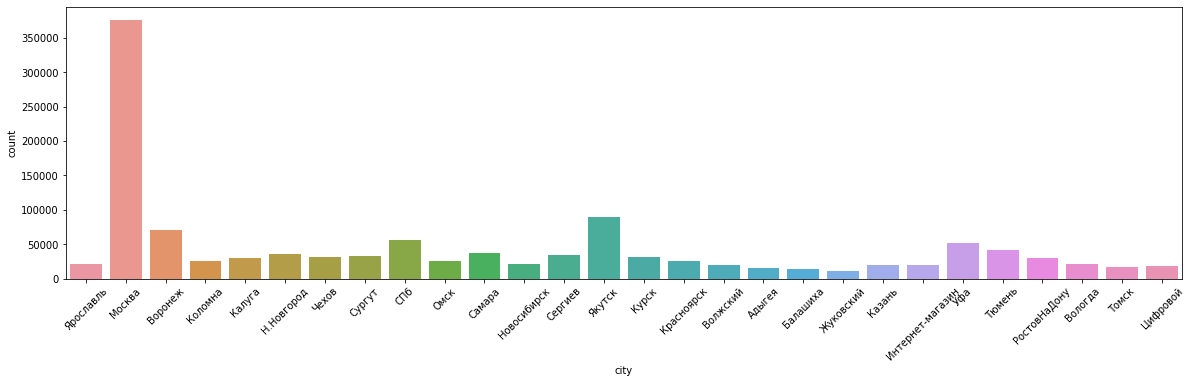

In [24]:
plt.figure(figsize=(20, 5))
city = sns.countplot(x='city', data=new_train)
city.set_xticklabels(city.get_xticklabels(), rotation=45);

Распределение покупок по магазинам.

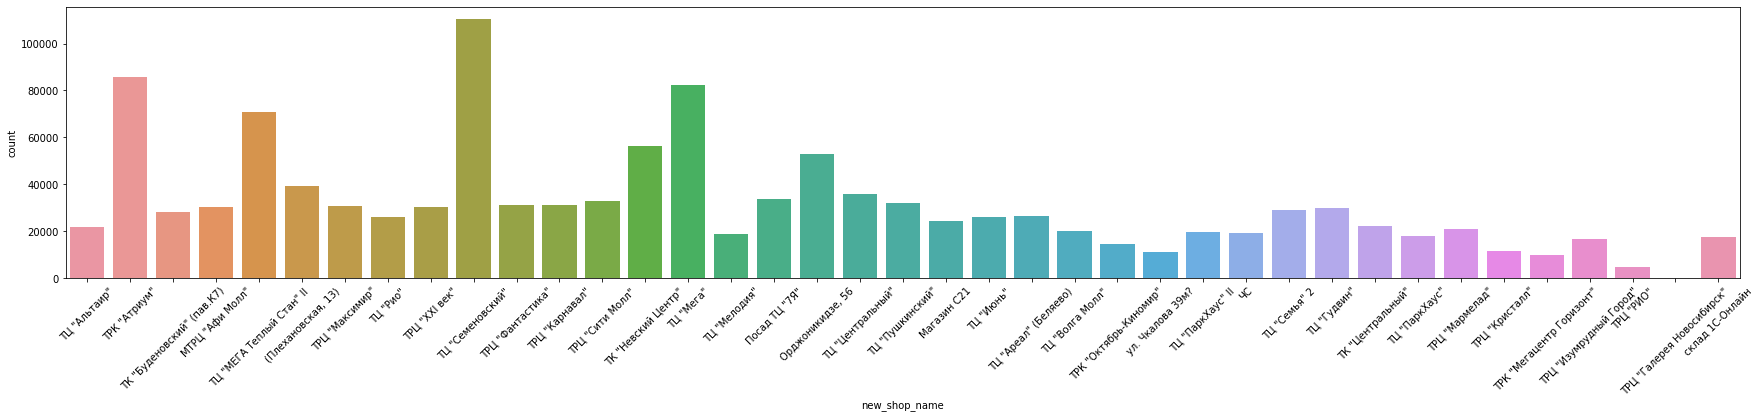

In [38]:
plt.figure(figsize=(30, 5))
shop_viz = sns.countplot(x='new_shop_name', data=new_train)
shop_viz.set_xticklabels(shop_viz.get_xticklabels(), rotation=45);

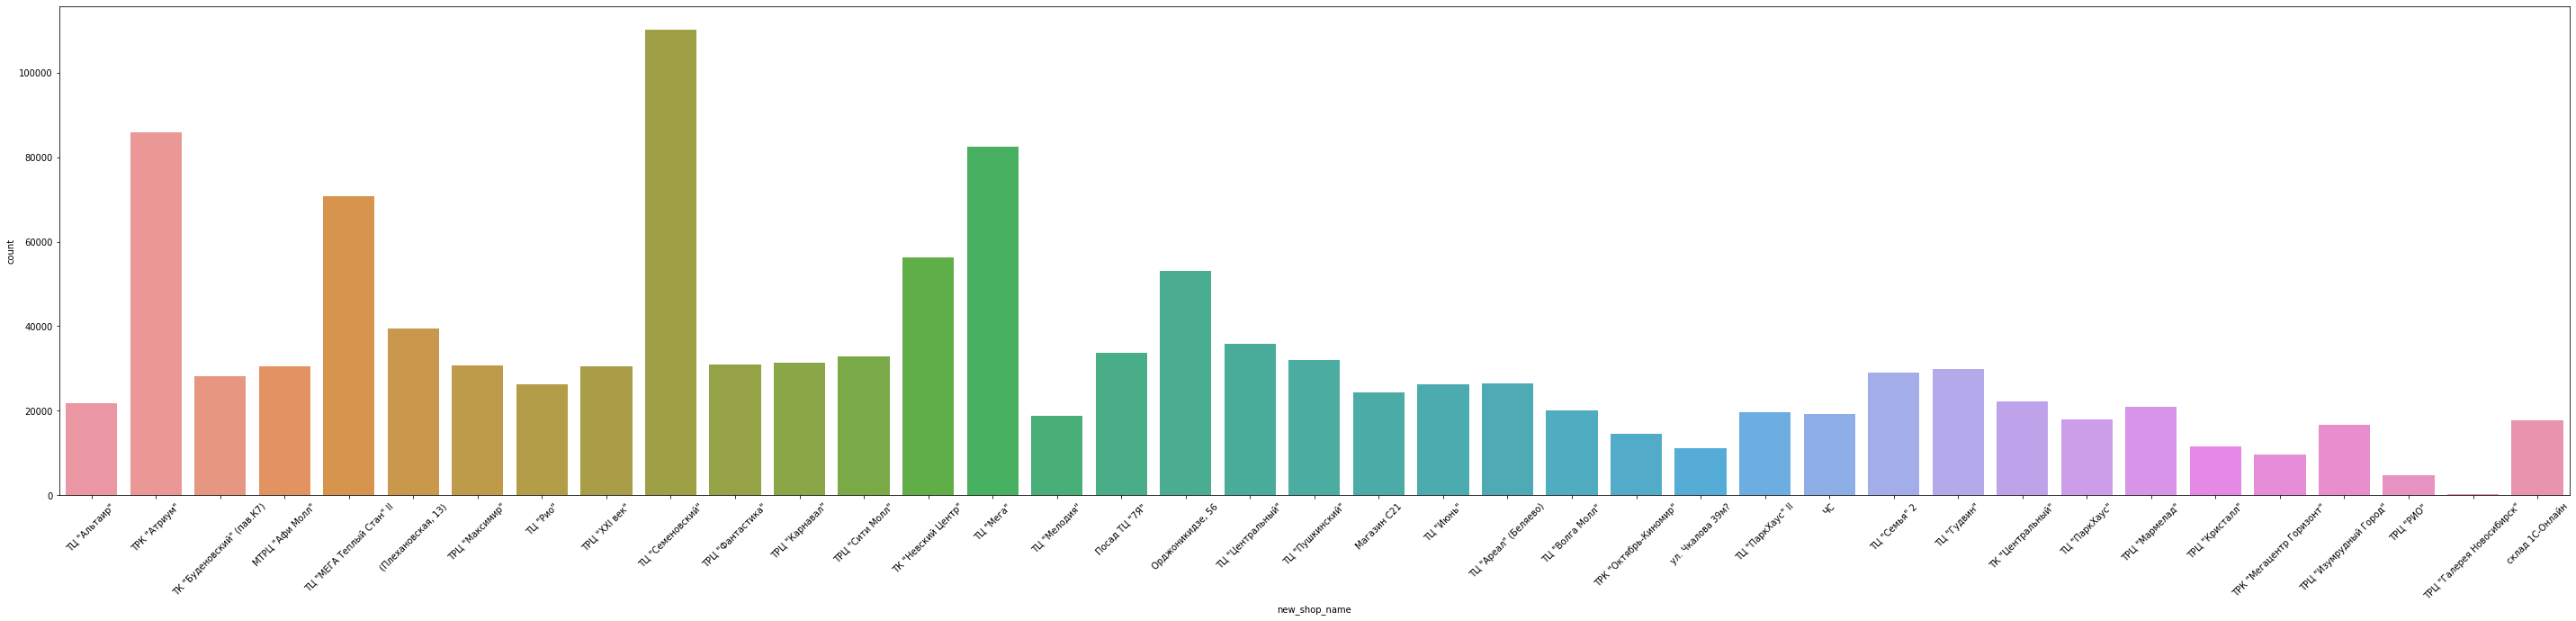

In [41]:
plt.figure(figsize=(50, 10))
shop_viz = sns.countplot(x='new_shop_name', data=new_train)
shop_viz.set_xticklabels(shop_viz.get_xticklabels(), rotation=45);

Распределение покупок по глобальным категориям.

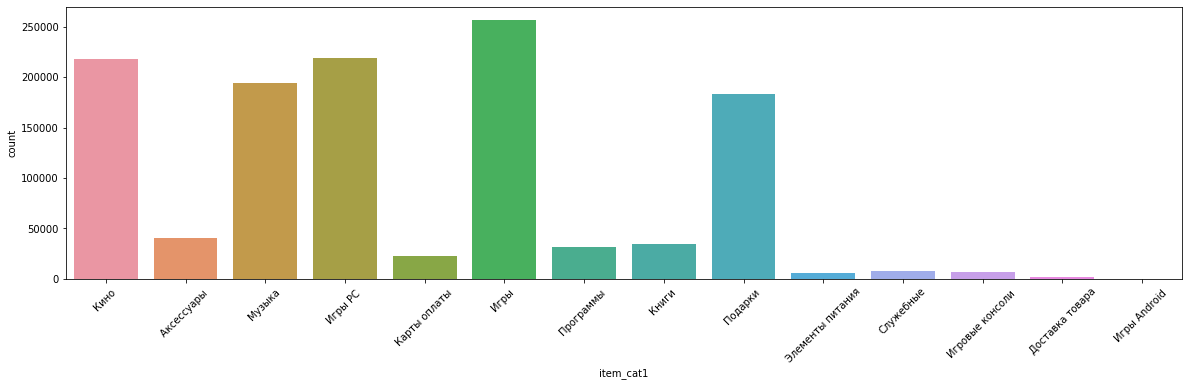

In [26]:
plt.figure(figsize=(20, 5))
item_name = sns.countplot(x='item_cat1', data=new_train)
item_name.set_xticklabels(item_name.get_xticklabels(), rotation=45);

Распределение покупок по локальным категориям.


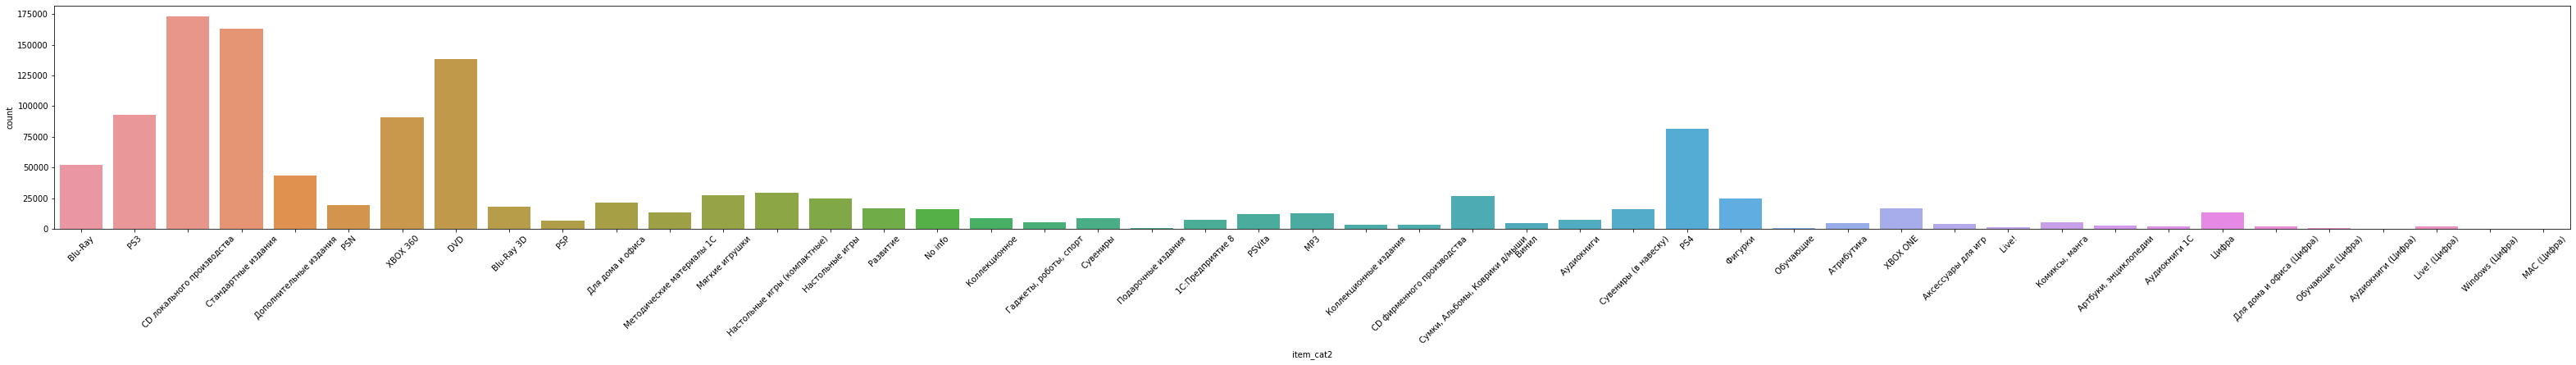

In [43]:
plt.figure(figsize=(55, 5))
item_label = sns.countplot(x='item_cat2', data=new_train)
item_label.set_xticklabels(item_label.get_xticklabels(), rotation=45);

Распределение покупок по месяцам.

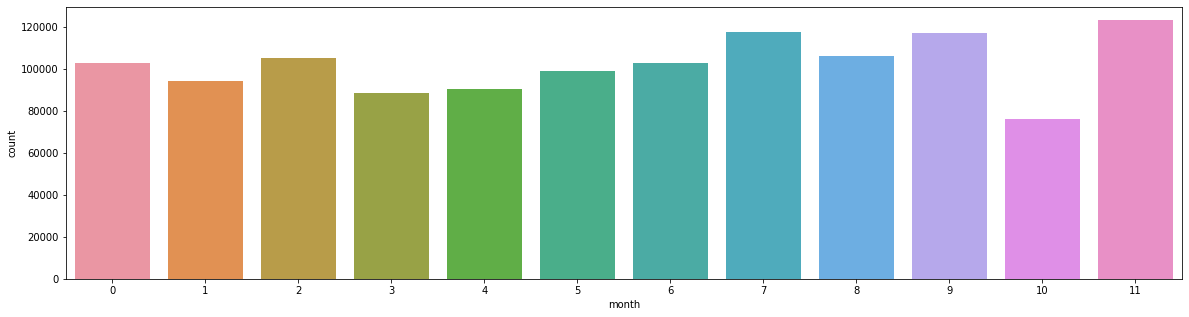

In [28]:
plt.figure(figsize=(20, 5))
sns.countplot(x='month', data=new_train);

# Подготавливаем данные для обучения моделей

In [8]:
X_train = new_train.drop(['item_cnt_day'], axis=1) # разделение на X и Y
Y_train = new_train['item_cnt_day']
X_test = new_test

In [9]:
cat_features = ['city', 'new_shop_name', 'item_cat1', 'item_cat2']

def into_numbers(data): # приводим к необходимому формату категориальные признаки
  num_data = pd.concat([data, pd.get_dummies(data['city'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat1'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat2'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['new_shop_name'])], axis=1)
  num_data.drop(cat_features, axis=1, inplace=True)
  return num_data

In [10]:
%%time
X_train_num = into_numbers(X_train.copy())
X_test_num = into_numbers(X_test.copy())

CPU times: user 3.02 s, sys: 1.14 s, total: 4.16 s
Wall time: 5.42 s


В train выборке отсутствуют 3 категории товаров, которые есть в test выборке, поэтому мы добавим их вручную в train выборке.

In [11]:
X_train_num[' Гарнитуры/Наушники'] = 0
X_train_num['PC ' ] = 0
X_train_num['Игры MAC '] = 0

Для XGBoost столбцы признаков должны быть в одном порядке и у train, и test выборок, поэтому мы отсортируем столбцы, чтобы получить одинаковый порядок столбцов.

In [12]:
X_train_num = X_train_num.reindex(sorted(X_train_num.columns), axis=1)
X_test_num = X_test_num.reindex(sorted(X_test_num.columns), axis=1)

Из-за того, что LightGBM не принимает не ascii-символы придется делать транслитерацию названий колонок.

In [13]:
def transliterate(name):
   # Словарь с заменами
   dictionary = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in dictionary:
      name = name.replace(key, dictionary[key])
   return name

In [14]:
eng_cols = {}
for i in X_train_num.columns:
    eng_cols[str(i)] = transliterate(i)

In [15]:
X_train_num.rename(columns=eng_cols, inplace=True)
X_test_num.rename(columns=eng_cols, inplace=True)

In [16]:
gc.collect()

60

# Создание моделей

In [17]:
import xgboost
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Разбиваем данные train выборки на выборку для обучения и отложенную выборку для проверки качества моделей.

In [18]:
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_train_num, Y_train, test_size=0.33, random_state=42) # нормализованные данные с использованием метода обработки категориальных признаков - get_dummies

Удалим старые данные, чтобы освободить ОЗУ.

In [19]:
del X_train_num
del Y_train
del X_train
del X_test
del items_cat
del items
del train
del sample_sub
del shops
del test
del new_train
del new_test
gc.collect()

40

In [45]:
model_error = {}

<a href="https://habr.com/ru/company/ods/blog/322076/">Классное объяснение методов</a>

# LinearRegression

Линейная регрессия, вероятно, является одним из наиболее важных и широко используемых методов регрессии. Это один из самых простых методов регрессии. Одним из его основных преимуществ является простота интерпретации результатов.

**Постановка проблемы**

При реализации линейной регрессии некоторой зависимой переменной 𝑦 на множестве независимых переменных 𝐱 = (𝑥₁,…, 𝑥ᵣ), где 𝑟 - число предикторов, вы предполагаете линейную зависимость между 𝑦 и 𝐱: 𝑦 = 𝛽₀ + 𝛽₁𝑥₁ + ⋯ + 𝛽ᵣ𝑥ᵣ + 𝜀. Это уравнение является уравнением регрессии. 𝛽₀, 𝛽₁,…, 𝛽ᵣ - коэффициенты регрессии, а 𝜀 - случайная ошибка.

Линейная регрессия вычисляет оценки коэффициентов регрессии или просто предсказанных весов, обозначенных как 𝑏₀, 𝑏₁,…, 𝑏ᵣ. Они определяют оценочную функцию регрессии 𝑓 (𝐱) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ + 𝑏ᵣ𝑥ᵣ. Эта функция должна достаточно хорошо фиксировать зависимости между входами и выходами.

Расчетный или прогнозируемый отклик 𝑓 (𝐱ᵢ) для каждого наблюдения 𝑖 = 1,…, 𝑛 должен быть как можно ближе к соответствующему фактическому отклику 𝑦ᵢ. Различия 𝑦ᵢ - 𝑓 (𝐱ᵢ) для всех наблюдений 𝑖 = 1,…, 𝑛 называются невязками. Регрессия заключается в определении наилучших прогнозируемых весов, то есть весов, соответствующих наименьшим остаткам.

Чтобы получить наилучшие веса, вы обычно минимизируете сумму квадратов невязок (SSR) для всех наблюдений 𝑖 = 1,…, 𝑛: SSR = Σᵢ (𝑦ᵢ - 𝑓 (𝐱ᵢ)) ². Этот подход называется методом наименьших квадратов.

**Производительность регрессии**

Изменение фактических ответов 𝑦ᵢ, 𝑖 = 1,…, 𝑛 происходит частично из-за зависимости от предикторов 𝐱ᵢ. Тем не менее, есть также дополнительная внутренняя дисперсия на выходе.

Коэффициент детерминации, обозначенный как 𝑅², говорит о том, какое количество изменений в 𝑦 можно объяснить зависимостью от 𝐱 с использованием конкретной регрессионной модели. Больший indicates² указывает на лучшее соответствие и означает, что модель может лучше объяснить изменение выходных данных с различными входными данными.

Значение 𝑅² = 1 соответствует SSR = 0, то есть идеально подходит, поскольку значения прогнозируемых и фактических ответов полностью соответствуют друг другу.

In [34]:
%%time
model_lr = LinearRegression()
model_lr.fit(X_train_check, y_train_check)

CPU times: user 10.6 s, sys: 1.15 s, total: 11.8 s
Wall time: 7.63 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
pred_lr = model_lr.predict(X_test_check)
lr_rmse = np.sqrt(mean_squared_error(y_test_check, pred_lr))
model_error['LinearRegression'] = lr_rmse
print(lr_rmse)

1.2009961798582207


# SGDRegressor

Линейная модель подбирается путем минимизации регуляризованных эмпирических потерь с SGD

Stochastic Gradient Descent (SGD) - это простой, но очень эффективный подход к дискриминационному обучению линейных классификаторов при использовании функций выпуклых потерь, таких как (линейные) машины опорных векторов и логистическая регрессия. Несмотря на то, что SGD существует в сообществе машинного обучения в течение длительного времени, совсем недавно ему уделялось значительное внимание в контексте широкомасштабного обучения.
SGD был успешно применен к крупномасштабным и редким проблемам машинного обучения, часто встречающимся в классификации текста и обработке естественного языка. Учитывая, что данных мало, классификаторы в этом модуле легко масштабируются до проблем с более чем 10 ^ 5 примерами обучения и более чем 10 ^ 5 функциями.

Преимущества стохастического градиентного спуска:
- Эффективность.
- Простота реализации (множество возможностей для настройки кода).

К недостаткам стохастического градиентного спуска относятся:
- SGD требует наличия ряда гиперпараметров, таких как параметр регуляризации и количество итераций.
- SGD чувствителен к масштабированию объектов.

**Regressor**

Класс SGDRegressor реализует простую процедуру обучения стохастического градиентного спуска, которая поддерживает различные функции потерь и штрафы для соответствия моделям линейной регрессии. SGDRegressor хорошо подходит для задач регрессии с большим количеством обучающих выборок (> 10.000), для других задач мы рекомендуем Ridge, Lasso или ElasticNet.

Конкретная функция потерь может быть установлена с помощью параметра `loss`. SGDRegressor поддерживает следующие функции потерь:
- loss = "squared_loss": обычные наименьшие квадраты,
- loss = "huber": потеря Хубера для устойчивой регрессии,
- loss = "epsilon_insensitive": линейная регрессия опорных векторов.

Функции гибкой и нечувствительной к эпсилону потери могут использоваться для надежной регрессии. Ширина нечувствительной области должна быть указана с помощью параметра `epsilon`. Этот параметр зависит от масштаба целевых переменных.

SGDRegressor поддерживает усредненный SGD в качестве SGDClassifier. Усреднение можно включить, установив значение `Average = True`.

Для регрессии с квадратом потерь и штрафом l2, другой вариант SGD со стратегией усреднения доступен с алгоритмом Stochastic Average Gradient (SAG), доступным в качестве решателя в Ridge.

In [32]:
%%time
model_sgd = SGDRegressor()
model_sgd.fit(X_train_check, y_train_check)

CPU times: user 15.6 s, sys: 679 ms, total: 16.3 s
Wall time: 16.5 s


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [33]:
pred_sgd = model_sgd.predict(X_test_check)
sgd_rmse = np.sqrt(mean_squared_error(y_test_check, pred_sgd))
model_error['SGDRegressor'] = sgd_rmse
print(sgd_rmse)

1.2092953590248496


# Lasso/ Ridge

Эти две техники применяются, если вам нужно уменьшить размерность данных и устранить проблему переобучения. Для этого применяются два способа:

L1-регуляризация — добавляет штраф к сумме абсолютных значений коэффициентов. Этот метод используется в лассо-регрессии.
L2-регуляризация — добавляет штраф к сумме квадратов коэффициентов. Этот метод используется в ридж-регрессии.
В большинстве случаев исследователи и разработчики предпочитают L2-функцию — она эффективнее с точки зрения вычислительных функций. С другой стороны, лассо-регрессия позволяет уменьшить значения некоторых коэффициентов до 0, то есть вывести из поля исследования лишние переменные. Это полезно, если на какое-либо явление влияют тысячи факторов и рассматривать все их оказывается бессмысленно.

Оба метода регуляризации объединены в технике эластичной сети. Она оптимально подходит, когда независимые переменные сильно коррелированы между собой. В этих случаях модель сможет попеременно применять L1- и L2-функции, в зависимости от того, какая лучше подходит с учетом входных данных.

## Ridge

In [23]:
%%time
model_ridge = Ridge()
model_ridge.fit(X_train_check, y_train_check)

CPU times: user 2.07 s, sys: 1.32 s, total: 3.39 s
Wall time: 3.59 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [24]:
pred_ridge = model_ridge.predict(X_test_check)
ridge_rmse = np.sqrt(mean_squared_error(y_test_check, pred_ridge))
model_error['Ridge'] = ridge_rmse
print(ridge_rmse)

1.2009967176923082


## Lasso 

In [28]:
%%time
model_lasso = Lasso()
model_lasso.fit(X_train_check, y_train_check)

CPU times: user 1.96 s, sys: 1.29 s, total: 3.25 s
Wall time: 3.03 s


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
pred_lasso = model_lasso.predict(X_test_check)
lasso_rmse = np.sqrt(mean_squared_error(y_test_check, pred_lasso))
model_error['Lasso'] = lasso_rmse
print(lasso_rmse)

1.3644989854092735


# XGBoost

XGBoost - это алгоритм, который в последнее время доминирует в прикладном машинном обучении и соревнованиях Kaggle для структурированных или табличных данных.

XGBoost - это реализация деревьев решений с градиентным усилением, разработанных для скорости и производительности.


**Зачем использовать XGBoost?**

Две причины использовать XGBoost также являются двумя целями проекта:

- Скорость исполнения.
- Модель Performance.

**Скорость выполнения XGBoost**

Как правило, XGBoost работает быстро. Действительно быстро по сравнению с другими реализациями повышения градиента.

Сцилард Пафка выполнил несколько объективных тестов, сравнивая производительность XGBoost с другими реализациями деревьев градиентного усиления и пакетных решений. Свои результаты он написал в мае 2015 года в своем блоге под названием «Сравнительный анализ реализации случайных лесов».

Он также предоставляет весь код на GitHub и более подробный отчет о результатах с точными числами.

**Производительность модели XGBoost**

XGBoost доминирует над структурированными или табличными наборами данных в задачах прогнозирования и классификации.

Доказательством тому является то, что это алгоритм выбора победителей конкурса на платформе конкурентной обработки данных Kaggle.

**Какой алгоритм использует XGBoost?**

Библиотека XGBoost реализует алгоритм дерева решений для повышения градиента.

Этот алгоритм имеет множество различных названий, таких как повышение градиента, несколько аддитивных деревьев регрессии, стохастическое повышение градиента или повышение градиента.

Повышение - это метод ансамбля, в который добавляются новые модели для исправления ошибок, допущенных существующими моделями. Модели добавляются последовательно, пока дальнейшие улучшения не могут быть сделаны. Популярным примером является алгоритм AdaBoost, который взвешивает точки данных, которые трудно предсказать.

Повышение градиента - это подход, при котором создаются новые модели, которые предсказывают невязки или ошибки предыдущих моделей, а затем складываются вместе, чтобы сделать окончательный прогноз. Это называется повышением градиента, потому что он использует алгоритм градиентного спуска, чтобы минимизировать потери при добавлении новых моделей.

Этот подход поддерживает как регрессионные, так и классификационные задачи прогнозного моделирования.

In [21]:
%%time
model_xgboost = xgboost.XGBRegressor()
model_xgboost.fit(X_train_check, y_train_check)

CPU times: user 13min 16s, sys: 14.3 s, total: 13min 30s
Wall time: 15min 11s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [22]:
pred_xgb = model_xgboost.predict(X_test_check)
xgboost_rmse = np.sqrt(mean_squared_error(y_test_check, pred_xgb))
model_error['XGBoost'] = xgboost_rmse
print(xgboost_rmse)

1.0447138471992472


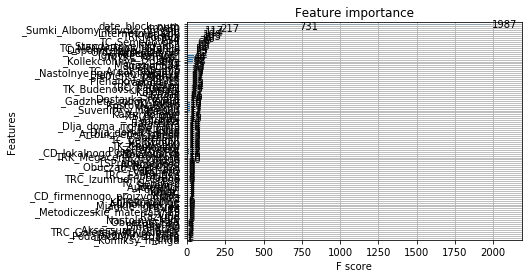

In [23]:
xgboost.plot_importance(model_xgboost) # график важности признаков

# RandomForest

RandomForest - это метаоценщик, который подходит к ряду классификационных деревьев решений по различным подвыборкам набора данных и использует усреднение для повышения точности прогнозирования и контроля соответствия. 

In [40]:
%%time
model_rf = RandomForestRegressor()
model_rf.fit(X_train_check, y_train_check)

CPU times: user 26min 58s, sys: 7.65 s, total: 27min 5s
Wall time: 1h 44min 58s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
pred_rf = model_rf.predict(X_test_check)
rf_rmse = np.sqrt(mean_squared_error(y_test_check, pred_rf))
model_error['RandomForest'] = rf_rmse
print(rf_rmse)

1.0572073214666975


# LightGBM

**LightGBM** - это платформа для повышения градиента, использующая алгоритмы обучения на основе дерева. Он предназначен для распространения и эффективности со следующими преимуществами:

- Более быстрая скорость обучения и высокая эффективность.
- Более низкое использование памяти.
- Лучшая точность.
- Поддержка параллельного и GPU обучения.
- Способен обрабатывать крупномасштабные данные.

In [42]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train_check, y_train_check)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
pred_lgbm = model_lgbm.predict(X_test_check)
lgbm_rmse = np.sqrt(mean_squared_error(y_test_check, pred_lgbm))
model_error['LightGBM'] = lgbm_rmse
print(lgbm_rmse)

1.048706763064606


Посмотрим на то как алгоритмы работают "из коробки"

In [44]:
full_rmse = 0
for key, value in model_error.items():
  full_rmse += value
  print("RMSE ошибка модели {} - {}".format(key, str(value)))
print("Среднее качество моделей - {}".format(str(full_rmse / len(model_error))))

RMSE ошибка модели SGDRegressor - 1.2092953590248496
RMSE ошибка модели Lasso - 1.3644989854092735
RMSE ошибка модели LinearRegression - 1.2009961798582207
RMSE ошибка модели XGBoost - 1.0447138471992472
RMSE ошибка модели RandomForest - 1.0572073214666975
RMSE ошибка модели LightGBM - 1.048706763064606
Среднее качество моделей - 1.1542364093371493


# Создадим файл с ответом

In [24]:
pred_for_sub = model_xgboost.predict(X_test_num)
len(pred_for_sub)

214200

In [27]:
result = pd.DataFrame({'ID':test.ID, 'item_cnt_month':pred_for_sub})
result

,ID,item_cnt_month
0,0,1.051541
1,1,1.066909
2,2,1.141300
3,3,1.062315
4,4,1.095508
...,...,...
214195,214195,1.057303
214196,214196,1.141973
214197,214197,1.026181
214198,214198,1.552083


In [29]:
result.to_csv("resul.csv", index=False)

# Выводы

По данным можно увидеть, что больше всего продаж в городе Москва и в категориях Игры, Подарки, Кино и Музыка. Также рассмотрели зависимость продаж от конкретного месяца, попробовали различные алгоритмы, выделили лучший. С помощью этого добились лучшего результата, а так же увидели, что задача решаема с помощью стандартных инструментов.